# Classifying sea ice and leads

This notebook aims to classify echoes from sea ice and leads from Sentinel-3 altimetry data. We will use a Gaussian Matrix Model, an unsupervised machine learning technique, to achieve this.

We first mount a Google drive so we can access data stored there:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


and set the path to the folder in which the data are stored:

In [ ]:
# replace this path with the path to the directory in which you saved the data
data_path = '/content/drive/MyDrive/UCL/Fourth_Year/ai4eo/week_4/data/'


## Read in necessary functions


We first install additonal packanges that we'll need for the analysis, import the packages we need, then load functions for processing the data.

In [ ]:
# install additional packages:
! pip install netCDF4
! import netCDF4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.2 MB/s eta 0:00:00
/bin/bash: line 1: import: command not found


Import packages and load functions:

In [ ]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree
import pyproj
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster

#=========================================================================================================
#===================================  SUBFUNCTIONS  ======================================================
#=========================================================================================================

#*args and **kwargs allow you to pass an unspecified number of arguments to a function,
#so when writing the function definition, you do not need to know how many arguments will be passed to your function
#**kwargs allows you to pass keyworded variable length of arguments to a function.
#You should use **kwargs if you want to handle named arguments in a function.
#double star allows us to pass through keyword arguments (and any number of them).
def peakiness(waves, **kwargs):
    '''Finds the peakiness of waveforms.'''

    import time
    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \

    print("Running peakiness function...")

    size=np.shape(waves)[0] #.shape property is a tuple of length .ndim containing the length of each dimensions
                            #Tuple of array dimensions.

    waves1=np.copy(waves)

    if waves1.ndim == 1: #number of array dimensions
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1)) #numpy.reshape(a, newshape, order='C'), a=array to be reshaped
        waves1=waves2

    # *args is used to send a non-keyworded variable length argument list to the function
    def by_row(waves, *args):
        '''Calculates the peakiness for each waveform.'''

        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky') #numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def unpack_gpod(variable):

    from scipy.interpolate import interp1d

    time_1hz = SAR_data.variables['time_01'][:]
    time_20hz = SAR_data.variables['time_20_ku'][:]
    time_20hzC = SAR_data.variables['time_20_c'][:]

    out = (SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out = np.ma.filled(out, np.nan)

    if len(out)==len(time_1hz):

        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)

    if len(out)==len(time_20hzC):
        print(variable, 'is c band, expanding to 20hz ku band dimension')
        out = interp1d(time_20hzC,out,fill_value="extrapolate")(time_20hz)
    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    from scipy import asarray as ar,exp
    do_plot='Off'

    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

    SSD = np.zeros(np.shape(RIP)[0])*np.nan
    x = np.arange(np.shape(RIP)[1])

    for i in range(np.shape(RIP)[0]):

        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])


    return SSD


## Load and pre-process data

Before we can analyse the altimetry waveforms, we must load and pre-process it. We load in the SAR data file, extract the variables we want to focus on, and process to find the peakiness (`PP`) and standard deviation (`SSD`) of each waveform. We then combine these statistics with the backscatter coeffient for large lakes for each waveform, and standardise these:

In [ ]:
# define path to directory in which the Sentinel 3 SAR data are stored
path = '/content/drive/MyDrive/UCL/Fourth_Year/ai4eo/week_4/data/'
SAR_file = 'S3B_SR_2_LAN_SI_20190301T231304_20190301T233006_20230405T162425_1021_022_301______LN3_R_NT_005.SEN3'
print('overlapping SAR file is',SAR_file)
SAR_data = Dataset(path + SAR_file+'/enhanced_measurement.nc')

# extract variables of interest
# sig0: the backscatter coefficient for large lakes
SAR_lat, SAR_lon, waves, sig_0, RIP, flag = unpack_gpod('lat_20_ku'), unpack_gpod('lon_20_ku'), unpack_gpod('waveform_20_ku'),unpack_gpod('sig0_water_20_ku'),unpack_gpod('rip_20_ku'),unpack_gpod('surf_type_class_20_ku') #unpack_gpod('Sigma0_20Hz')
SAR_index = np.arange(np.size(SAR_lat))

# subset the data to the range we are interested in
find = np.where(SAR_lat >= -99999) #60
SAR_lat = SAR_lat[find]
SAR_lon = SAR_lon[find]
SAR_index = SAR_index[find]
waves = waves[find]
sig_0 = sig_0[find]
RIP = RIP[find]

# calculate the peakiness and sample standard deviartion, and convert to numpy arrays
PP = peakiness(waves)
SSD = calculate_SSD(RIP)
sig_0_np = np.array(sig_0)
RIP_np = np.array(RIP)
PP_np = np.array(PP)
SSD_np = np.array(SSD)

# combine the backscatter coefficient for large lakes, the peakiness and the standard deviation for each waveform
data = np.column_stack((sig_0_np, PP_np, SSD_np))
# standardize these data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)


overlapping SAR file is S3B_SR_2_LAN_SI_20190301T231304_20190301T233006_20230405T162425_1021_022_301______LN3_R_NT_005.SEN3
Running peakiness function...


<ipython-input-4-0319e468a61e>:59: RuntimeWarning: Mean of empty slice
  noise_floor=np.nanmean(waves[10:20])


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


We can now check the shape of `waves`, which stores our waveforms:

In [ ]:
print(f'Shape of waves: {waves.shape}')

Shape of waves: (13101, 256)


`waves` contains 13,101 waveforms of 256 points each. Let's plot three of these, waveforms 1000, 2000 and 3000:


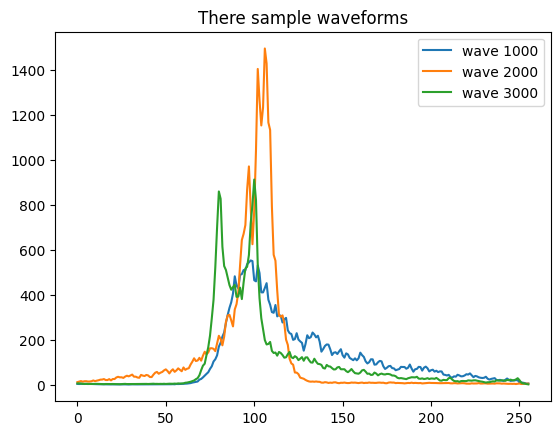

In [ ]:
plt.plot(waves[1000], label='wave 1000')
plt.plot(waves[2000], label='wave 2000')
plt.plot(waves[3000], label='wave 3000')
plt.title('There sample waveforms')
plt.legend()


We will now clean `waves` and `flag` by removing NaNs and storing only waveforms for sea ice and leads. Each waveform has a `flag` representing it -- a flag of 1 represents sea ice and a flag of 2 represents leads.

In [19]:
# check the number of NaNs in the data
nan_count = np.isnan(data_normalized).sum()
print(f"Number of NaN values in the array: {nan_count}")

# clean flag, waves and data
flag_cleaned = flag[~np.isnan(data_normalized).any(axis=1)]
waves_cleaned = waves[~np.isnan(data_normalized).any(axis=1)][(flag_cleaned==1)|(flag_cleaned==2)]
data_cleaned = data_normalized[~np.isnan(data_normalized).any(axis=1)][(flag_cleaned==1)|(flag_cleaned==2)]
print(f'Spape of cleaned data: {data_cleaned.shape}')
print(f'Shape of cleaned waves: {waves_cleaned.shape}')


Number of NaN values in the array: 387
Spape of cleaned data: (6849, 3)
Shape of cleaned waves: (6849, 256)


In [22]:
np.shape(flag_cleaned==2)

(12815,)

There are 6,849 waveforms in `waves_cleaned`. Let's now plot every hundredth waveform with a flag of 1 (sea ice), and every hundredth with a flag of 2 (lead) -- these are the official ESA classifications:

Text(0.5, 1.0, 'Waveforms with a flag of 2 (lead)')

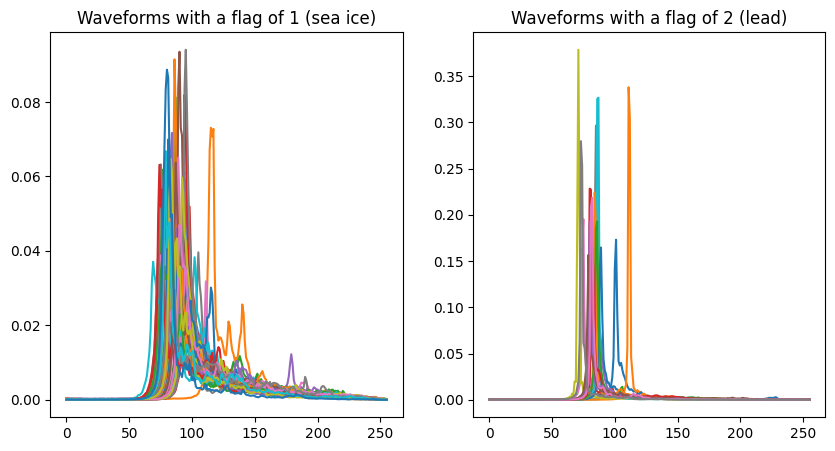

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

functions_to_plot = waves[~np.isnan(data_normalized).any(axis=1)][(flag_cleaned==1)][::100]
# Plot each function
for i, function in enumerate(functions_to_plot):
    ax1.plot(function/np.sum(function))
ax1.set_title('Waveforms with a flag of 1 (sea ice)')

functions_to_plot = waves[~np.isnan(data_normalized).any(axis=1)][(flag_cleaned==2)][::100]
# Plot each function
for i, function in enumerate(functions_to_plot):
    ax2.plot(function/np.sum(function))
ax2.set_title('Waveforms with a flag of 2 (lead)')


## GMM Model

We will now classify the waveforms ourselves as either ice or leads. We will use a Gaussian Mixture Model (GMM) for this.

GMMs are a probabilistic model for representing normally distributed subpopulations within an overall population. The model assumes that the data is generated from a mixture of several Gaussian distributions, each with its own mean and variance {cite}`reynolds2009gaussian, mclachlan2004finite`. GMMs are widely used for clustering and density estimation, as they provide a method for representing complex distributions through the combination of simpler ones.

### Why Gaussian Mixture Models for Clustering?

Gaussian Mixture Models are particularly powerful in scenarios where:

- **Soft clustering is needed**: Unlike K-means, GMM provides the probability of each data point belonging to each cluster, offering a soft classification and understanding of the uncertainties in our data.
- **Flexibility in cluster covariance**: GMM allows for clusters to have different sizes and different shapes, making it more flexible to capture the true variance in the data.

### Key Components of GMM

1. **Number of Components (Gaussians)**: Similar to K in K-means, the number of Gaussians (components) is a parameter that needs to be set.
2. **Expectation-Maximization (EM) Algorithm**: GMMs use the EM algorithm for fitting, iteratively improving the likelihood of the data given the model.
3. **Covariance Type**: The shape, size, and orientation of the clusters are determined by the covariance type of the Gaussians (e.g., spherical, diagonal, tied, or full covariance).

### Advantages of GMM

- **Soft Clustering**: Provides a probabilistic framework for soft clustering, giving more information about the uncertainties in the data assignments.
- **Cluster Shape Flexibility**: Can adapt to ellipsoidal cluster shapes, thanks to the flexible covariance structure.

We will now proceed with running the GMM, using two classifications (ice and lead, `n_components = 2`).

In [ ]:
# fit the GMM and predict clusters
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data_cleaned)
clusters_gmm = gmm.predict(data_cleaned)


We can now see how many waveforms are in each classification:

In [ ]:
unique, counts = np.unique(clusters_gmm, return_counts=True)
class_counts = dict(zip(unique, counts))

print(f'Number of waveforms classified as ice (clusters_gmm = 0): {class_counts[0]}')
print(f'Number of waveforms classified as leads (clusters_gmm = 1): {class_counts[1]}')


Number of waveforms classified as ice (clusters_gmm = 0): 5013
Number of waveforms classified as leads (clusters_gmm = 1): 1836


Now let's plot every hundredth waveform where `clusters_gmm` is equal to 0, i.e. waveforms classified as ice, and every hundredth waveform where `clusters_gmm` is equal to 1, i.e. waveforms classified as leads:

Text(0.5, 1.0, 'Waveforms classified as leads')

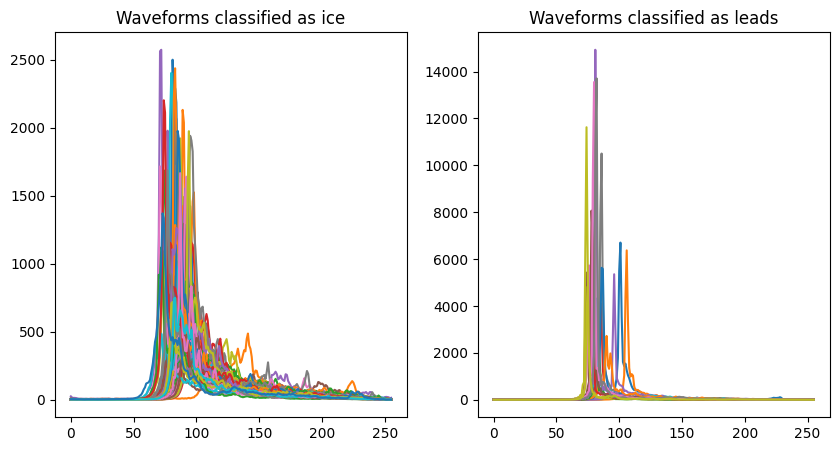

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

functions_to_plot = waves_cleaned[clusters_gmm == 0][::100]
# plot each function
for i, function in enumerate(functions_to_plot):
    ax1.plot(function)
ax1.set_title('Waveforms classified as ice')

functions_to_plot = waves_cleaned[clusters_gmm == 1][::100]
# plot each function
for i, function in enumerate(functions_to_plot):
    ax2.plot(function)
ax2.set_title('Waveforms classified as leads')


The waveforms classified as leads have higher peaks and a smaller standard deviation than those classified as ice. Let's now see how our classification compares to the official ESA classification:

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5086
         1.0       0.96      1.00      0.98      1763

    accuracy                           0.99      6849
   macro avg       0.98      0.99      0.99      6849
weighted avg       0.99      0.99      0.99      6849



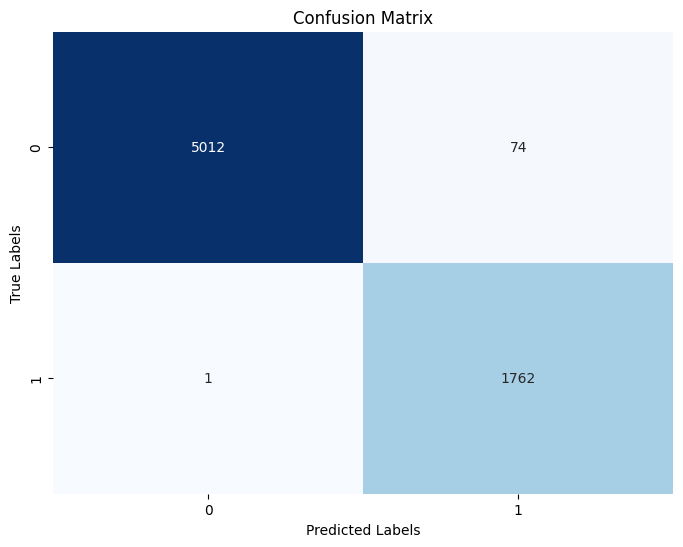

Accuracy: 0.99


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# filter the flags to just have 1s (ice) and 2s (leads), then covert these to 0s
#   and 1s for comparison
flags = flag_cleaned[(flag_cleaned==1) | (flag_cleaned==2)]
flags[flags==1] = 0
flags[flags==2] = 1

# calculate confusion matrix
cm = confusion_matrix(flags, clusters_gmm)

# calculate accuracy
accuracy = accuracy_score(flags, clusters_gmm)

# display classification report
report = classification_report(flags, clusters_gmm)
print("Classification Report:\n", report)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# display accuracy
print(f"Accuracy: {accuracy:.2f}")


Our confusion matrix shows that we have very successfully classified the ice and lead echoes, with an accuracy of 99% when compared with the official ESA classifications.  These waveforms all peak in different places though, so we will now use the `msalign` function to align them, in order to analyse them more meaningfully:

In [ ]:
! pip install msalign

In [ ]:
from msalign import msalign

# this takes a few minutes to run. X is the waveform separation unit, and 75 is
#   the reference peak to which the waveform peaks will be aligned. The cleaned
#   waveforms need to be transposed to be in the correct format for the function.
#   We do this for the waveforms classified as ice and the waveforms classified
#   as leads seperately.
X = range(256)
aligned_ice = msalign(X, waves_cleaned[clusters_gmm==0].T, [75])
aligned_leads = msalign(X, waves_cleaned[clusters_gmm==1].T, [75])


/usr/local/lib/python3.10/dist-packages/msalign/utilities.py:106: UserWarning: The input array was rotated to match the x-axis input
  warnings.warn("The input array was rotated to match the x-axis input", UserWarning)


We can now plot and compare the aligned and unaligned waveforms classified as ice:



Text(0.5, 1.0, 'Unaligned waveforms, ice')

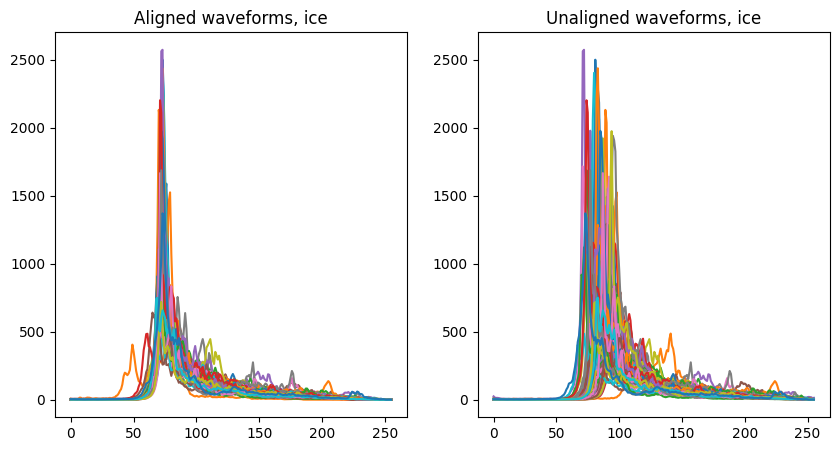

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

functions_to_plot = aligned_ice[::100]
# plot each function
for i, function in enumerate(functions_to_plot):
    ax1.plot(function)
ax1.set_title('Aligned waveforms, ice')

functions_to_plot = waves_cleaned[clusters_gmm==0][::100]
# plot each function
for i, function in enumerate(functions_to_plot):
    ax2.plot(function)#, label=f'Function {i+1}')
ax2.set_title('Unaligned waveforms, ice')


This doesn't perfectly align all the smaller peaks, but it is certainly an improvement and will allow for a more meaningful comparison between waveforms. We can do the same for the waveforms classified as leads:

Text(0.5, 1.0, 'Unaligned waveforms, lead')

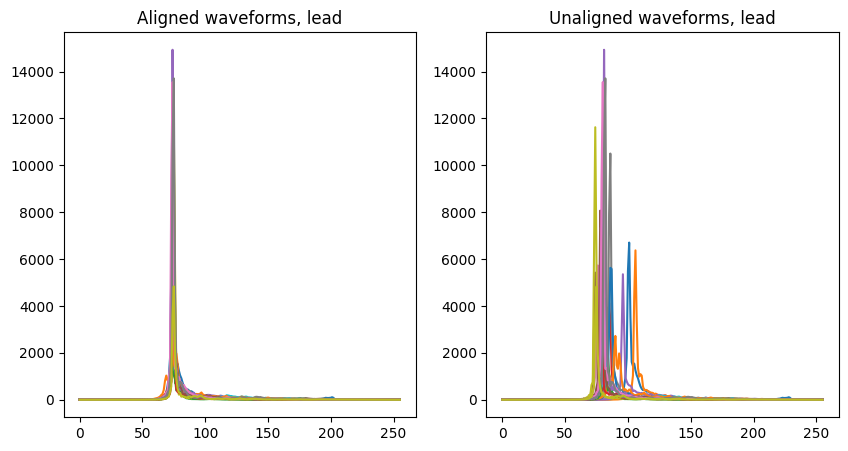

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

functions_to_plot = aligned_leads[::100]
# Plot each function
for i, function in enumerate(functions_to_plot):
    ax1.plot(function)
ax1.set_title('Aligned waveforms, lead')

functions_to_plot = waves_cleaned[clusters_gmm==1][::100]
# Plot each function
for i, function in enumerate(functions_to_plot):
    ax2.plot(function)#, label=f'Function {i+1}')
ax2.set_title('Unaligned waveforms, lead')


The aligned waveforms classified as leads line up much more neatly. Let's now find and plot the mean and standard deviation of the aligned and unaligned waveforms:

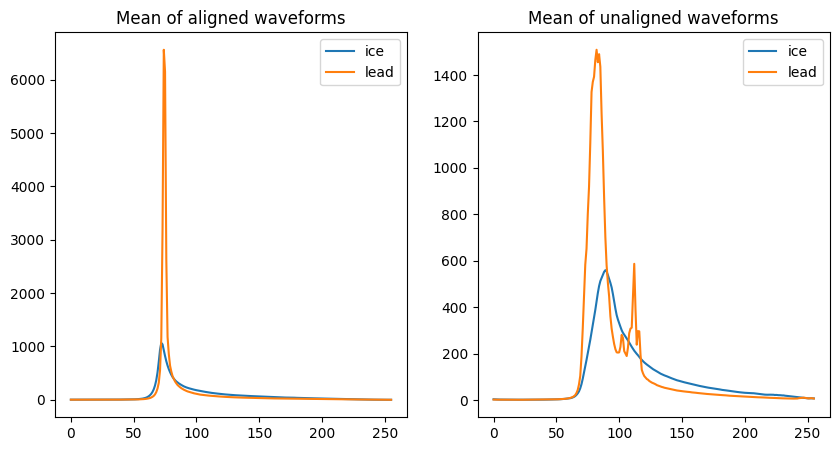

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

ax1.plot(np.mean(aligned_ice, axis=0), label='ice')
ax1.plot(np.mean(aligned_leads, axis=0), label='lead')
ax1.set_title('Mean of aligned waveforms')
ax1.legend()

ax2.plot(np.mean(waves_cleaned[clusters_gmm==0], axis=0), label='ice')
ax2.plot(np.mean(waves_cleaned[clusters_gmm==1], axis=0), label='lead')
ax2.set_title('Mean of unaligned waveforms')
ax2.legend()


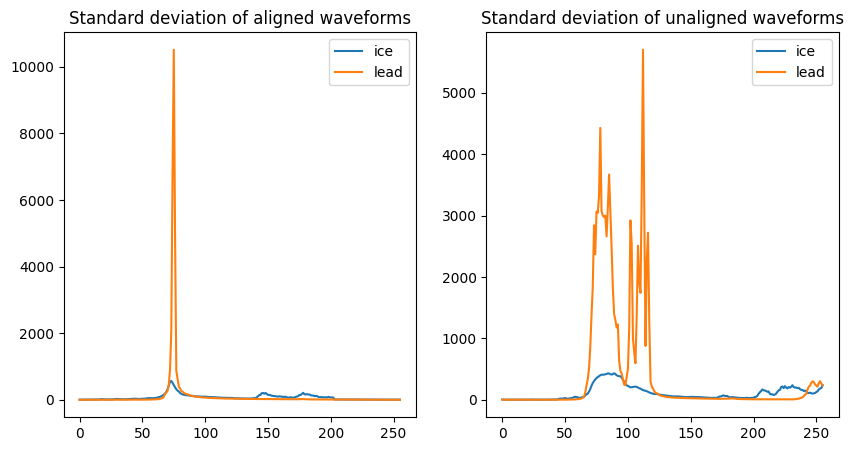

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

ax1.plot(np.std(aligned_ice, axis=0), label='ice')
ax1.plot(np.std(aligned_leads, axis=0), label='lead')
ax1.set_title('Standard deviation of aligned waveforms')
ax1.legend()

ax2.plot(np.std(waves_cleaned[clusters_gmm==0], axis=0), label='ice')
ax2.plot(np.std(waves_cleaned[clusters_gmm==1], axis=0), label='lead')
ax2.set_title('Standard deviation of unaligned waveforms')
ax2.legend()


Aligning the waveform peaks gives mean waveforms each with a single peak, which is more representative of the individual waveforms, rather than the unaligned mean which has multiple peaks. The standard deviation is also more consistent -- for leads, there is a lot of variation in the height of the peak, but the peak falls in the same place. For sea ice, there is a little more variation in the location of the peak, but there is less difference in the heights of the peak.